# Importing the Dependencies

In [1]:
#Importing the required Dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [2]:
tf.test.is_built_with_cuda()


True

In [3]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Read the Dataset

In [4]:
annotation_file = "C:\\Users\\Administrator\\Downloads\\annotations_trainval2014\\annotations\\captions_train2014.json"

In [5]:
image_folder = 'C:\\Users\\Administrator\\Downloads\\train2014\\train2014\\'

#Preprocessing

In [6]:
with open(annotation_file,'r') as f:
    annotations = json.load(f)

#Storing captions and Image names in vectors

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> '+annot['caption']+' <end>'
    image_id = annot['image_id']
    full_coco_image_path = image_folder+"COCO_train2014_"+'%012d.jpg' % (image_id)
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

#Shuffling captions anf image names

train_captions,img_name_vectors = shuffle(all_captions,all_img_name_vector,
                                            random_state = 1)

train_captions = train_captions
img_name_vectors = img_name_vectors

In [7]:
print(len(train_captions),len(all_captions))

414113 414113


In [8]:
def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,(299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    #file_path = "/content/gdrive/MyDrive/Pickle"+file_path[11:]
    print(file_path)
    return img,file_path

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

In [ ]:
#Get unique Images
encode_train = sorted(set(img_name_vectors))

#Creating the Bottle Neck Features and saving it using pickle
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image,num_parallel_calls = 
                                  tf.data.experimental.AUTOTUNE).batch(64)

for img,path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0],-1,batch_features.shape[3]))
    for bf,p in zip(batch_features,path):
        temp = p.numpy().decode("utf-8")
        temp = ".\pickle"+temp[52:]
        path_of_feature = temp
        np.save(path_of_feature,bf.numpy())

## Preprocessing the captions

In [10]:
def calc_max_length(tensor):
      return max(len(t) for t in tensor )

In [11]:
top_k = 9000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token='<unk>',
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [13]:
#Splitting the data into training and testing
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vectors,cap_vector,
                                                                    test_size=0.001,
                                                                    random_state=0)

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE=1000
embedding_dim = 256
units=512
vocab_size = top_k+1
num_steps = len(img_name_train) // BATCH_SIZE
'''Shape of the vector extracted from InceptionV3 is (64, 2048)'''
features_shape = 2048
attention_features_shape = 64

In [15]:
#Load the numpy files
def map_func(image_name,cap):
    img_tensor = np.load(image_name.decode('utf-8')+'.npy')
    return img_tensor,cap

## Creating Tensorflow Dataset Object

In [16]:
for i,name in enumerate(img_name_train):
      img_name_train[i] = ".\\pickle"+name[52:]

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                      map_func,[item1,item2],[tf.float32,tf.int32]),              
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
#To ensure that our dataset has been created
a,b = next(iter(dataset))

# Creating the Model

In [19]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self,units):
        super(BahdanauAttention,self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V1 = tf.keras.layers.Dense(1)

    def call(self,features,hidden):
        hidden_with_time_axis = tf.expand_dims(hidden,1)
        score = tf.nn.tanh(self.W1(hidden_with_time_axis)+
                           self.W2(features))
        attention_weights = tf.nn.softmax(self.V1(score),axis=1)


        context_vector = attention_weights*features
        context_vector = tf.reduce_sum(context_vector,axis=1)
        return context_vector,attention_weights

In [20]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self,embedding_dim):
        super(CNN_Encoder,self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self,x):
        x = self.fc(x)
        x = tf.nn.tanh(x)
        return x

In [21]:
class RNN_Decoder(tf.keras.Model):
      def __init__(self,embedding_dim,units,vocab_size):
        super(RNN_Decoder,self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.GRU = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer = 'glorot_uniform')
        self.drop1 = tf.keras.layers.Dropout(0.4)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.fc1 = tf.keras.layers.Dense(512)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self,x,features,hidden):
        context_vector,attention_weights = self.attention(features,hidden)
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)

        output,state = self.GRU(x)
        x = self.fc1(output)
        x = self.drop1(x)
        x = self.batch_norm(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x,state,attention_weights

    def reset_state(self,batch_sz):
        return tf.zeros([batch_sz,self.units])

In [22]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim,units,vocab_size)

In [23]:
#Loss and Optimizer
optimizer=tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

To restore the saved weights we hve to initialize the custom Models first

In [24]:
#Initializing using Random Input
test_x = encoder(np.ones([1,64,2048]))
encoder.load_weights("weights1.hdf5")
b = decoder.attention(test_x,decoder.reset_state(BATCH_SIZE))
c = decoder(tf.expand_dims([tokenizer.word_index['<start>']]*BATCH_SIZE,1),test_x,decoder.reset_state(BATCH_SIZE))
decoder.load_weights("weights2.hdf5")
decoder.attention.load_weights("weights3.hdf5")

Weights for this model can be downloaded from :-

[encoder](https://drive.google.com/file/d/10kEzsnO9jggFoilJpNojFWxNqZyuyIk6/view?usp=sharing)....[decoder](https://drive.google.com/file/d/16c96A8lrJ3H9IC7sfs1rZ7-vh6hmaJMp/view?usp=sharing)....
....[attetion](https://drive.google.com/file/d/1-8qgXKYmNO8knd1gESNrz62FGDPIYBs-/view?usp=sharing)

In [25]:
#In case we need to store the model as checkpoint
ckpt_path = ".\model_checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimzer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,ckpt_path,max_to_keep=3)
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from .\model_checkpoint\ckpt-3


In [26]:
#To plot attention
loss_plot = []

# Training

In [27]:
def train_step(img_tensor,target):
    loss = 0
    hidden = decoder.reset_state(batch_sz=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0],1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(target.shape[1]):
            prediction,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i],prediction)
            dec_input = tf.expand_dims(target[:,i],1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables+decoder.trainable_variables
    gradients = tape.gradient(loss,trainable_variables)
    optimizer.apply_gradients(zip(gradients,trainable_variables))
    return loss, total_loss

In [43]:
with tf.device('/gpu:0'):
    EPOCHS = 10
    for epoch in range(EPOCHS):
      start = time.time()
      total_loss = 0
      for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor,target)
        total_loss += t_loss
        if batch%100 == 0:
            print("Epoch:{}.....Batch:{}.....Loss:{}".format(epoch+1,
                                                             batch,batch_loss.numpy() / int(target.shape[1])))

        loss_plot.append(total_loss/num_steps)
      if epoch%1==0:
          ckpt_manager.save()
          encoder.save_weights("weights1.hdf5",overwrite=True)
          decoder.attention.save_weights("weights3.hdf5",overwrite=True)
          decoder.save_weights("weights2.hdf5",overwrite=True)
      print('Epcoh:{}...................Loss:{}'.format(epoch+1,total_loss/num_steps))
      print("Time Taken __ {:.3f} sec".format(time.time()-start))

Epoch:1.....Batch:0.....Loss:0.43787362025334287
Epoch:1.....Batch:100.....Loss:0.47154837388258714
Epoch:1.....Batch:200.....Loss:0.43196986271784854
Epoch:1.....Batch:300.....Loss:0.41922136453481823
Epoch:1.....Batch:400.....Loss:0.41469830733079177
Epoch:1.....Batch:500.....Loss:0.42261578486515927
Epoch:1.....Batch:600.....Loss:0.3782488382779635
Epoch:1.....Batch:700.....Loss:0.3463372817406288
Epoch:1.....Batch:800.....Loss:0.39876615084134615
Epoch:1.....Batch:900.....Loss:0.4286308288574219
Epoch:1.....Batch:1000.....Loss:0.4208380625798152
Epoch:1.....Batch:1100.....Loss:0.40391940336961013
Epoch:1.....Batch:1200.....Loss:0.3864340048569899
Epoch:1.....Batch:1300.....Loss:0.3844141960144043
Epoch:1.....Batch:1400.....Loss:0.41285232397226185
Epoch:1.....Batch:1500.....Loss:0.4109217937176044
Epoch:1.....Batch:1600.....Loss:0.44863733878502476
Epoch:1.....Batch:1700.....Loss:0.41534724602332485
Epoch:1.....Batch:1800.....Loss:0.43593857838557315
Epoch:1.....Batch:1900.....Loss

KeyboardInterrupt: 

In [29]:
max_length

52

In [30]:
attention_features_shape

64

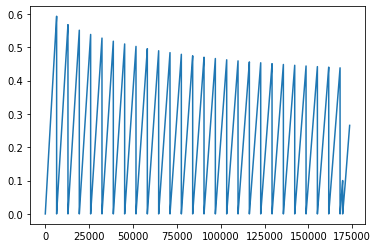

In [44]:
plt.plot(loss_plot)

In [42]:
with open('tokenizer1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)